In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import ants
import matplotlib.pyplot as plt

from dp_model import dp_utils as dpu, dp_loss as dpl
from dp_model.model_files.sfcn import SFCN
from dp_model.evaluation import predict_and_eval

from utils import explore_3D_array

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'CUDA using the device: {device}')

CUDA using the device: cuda


### Preprocessing:
SFCN UKB preprocessed with:
1. skull strip: BET (FSL)
2. bias correction: FAST(-B) (FSL)
3. linear registration (on MNI1 152; 1mm): FLIRT (FSL)
4. crop (160 * 192 * 160)
5. mean normalization

IXI is processed with:
1. bias correction: ANTs N4 bias field corr. (more robust for non-UKB dataset)
2. skull strip: HD-BET (more robust)
3. ANTs `registration(...)` and `apply_transforms(...)` (ANTs tool is as accurate as FLIRT and sometimes beter for cross-site)
4. crop
5. mean normalization


In [4]:
ixi_csv = Path('data/IXI/sampled_age_44_80.csv')
df = pd.read_csv(ixi_csv)

# adding preprocessed image path to use dp_model.evaluation.BrainAgeDataset
mni_reg_dir = Path('data/IXI/T1/mni_reg')
df['PREPROCESSED_IMAGE_PATH'] = df['IMAGE_PATH'].apply(
    lambda path: str(mni_reg_dir / Path(path).name)
)

example_row = df.iloc[10]
processed_image_file, true_age = Path(example_row['PREPROCESSED_IMAGE_PATH']), example_row['AGE']
print(f"Processed image file: {processed_image_file}")
print(f"True age: {true_age}")

df.head(10)

Processed image file: data/IXI/T1/mni_reg/IXI055-Guys-0730-T1.nii.gz
True age: 49.4


,IXI_ID,AGE,IMAGE_PATH,PREPROCESSED_IMAGE_PATH
0,13,46.71,data/IXI/T1/raw/IXI013-HH-1212-T1.nii.gz,data/IXI/T1/mni_reg/IXI013-HH-1212-T1.nii.gz
1,16,55.17,data/IXI/T1/raw/IXI016-Guys-0697-T1.nii.gz,data/IXI/T1/mni_reg/IXI016-Guys-0697-T1.nii.gz
2,19,58.66,data/IXI/T1/raw/IXI019-Guys-0702-T1.nii.gz,data/IXI/T1/mni_reg/IXI019-Guys-0702-T1.nii.gz
3,28,74.03,data/IXI/T1/raw/IXI028-Guys-1038-T1.nii.gz,data/IXI/T1/mni_reg/IXI028-Guys-1038-T1.nii.gz
4,29,59.22,data/IXI/T1/raw/IXI029-Guys-0829-T1.nii.gz,data/IXI/T1/mni_reg/IXI029-Guys-0829-T1.nii.gz
5,40,44.09,data/IXI/T1/raw/IXI040-Guys-0724-T1.nii.gz,data/IXI/T1/mni_reg/IXI040-Guys-0724-T1.nii.gz
6,44,44.85,data/IXI/T1/raw/IXI044-Guys-0712-T1.nii.gz,data/IXI/T1/mni_reg/IXI044-Guys-0712-T1.nii.gz
7,48,50.65,data/IXI/T1/raw/IXI048-HH-1326-T1.nii.gz,data/IXI/T1/mni_reg/IXI048-HH-1326-T1.nii.gz
8,50,63.19,data/IXI/T1/raw/IXI050-Guys-0711-T1.nii.gz,data/IXI/T1/mni_reg/IXI050-Guys-0711-T1.nii.gz
9,53,53.31,data/IXI/T1/raw/IXI053-Guys-0727-T1.nii.gz,data/IXI/T1/mni_reg/IXI053-Guys-0727-T1.nii.gz


In [5]:
image = ants.image_read(str(processed_image_file))
print(image.get_orientation())
explore_3D_array(image.reorient_image2('IAR').numpy())


RPI


interactive(children=(IntSlider(value=90, description='SLICE', max=181), Output()), _dom_classes=('widget-inte…

In [6]:
data_np: np.ndarray = image.numpy()

data_np = data_np / data_np.mean()

# data_min = data_np.min()
# data_max = data_np.max()
# data_np = (data_np - data_min) / (data_max - data_min)

data_np = dpu.crop_center(data_np, (160, 192, 160))

vis_data = data_np.transpose(2, 1, 0)[:, ::-1, :]  # reorient to IRA for visualization (numpy)
explore_3D_array(vis_data)

interactive(children=(IntSlider(value=79, description='SLICE', max=159), Output()), _dom_classes=('widget-inte…

Input data shape: torch.Size([1, 1, 160, 192, 160])
dtype: torch.float32
Label shape: torch.Size([1, 40])
Output shape: torch.Size([1, 40])


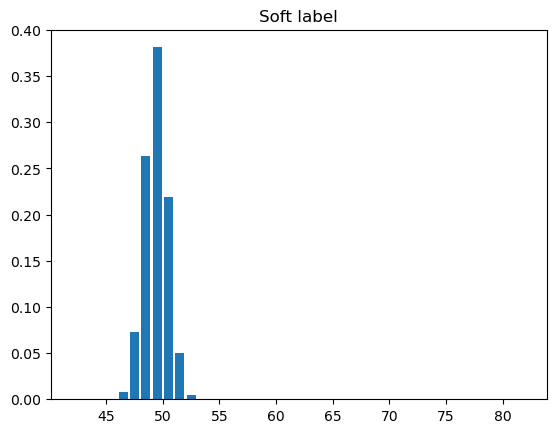

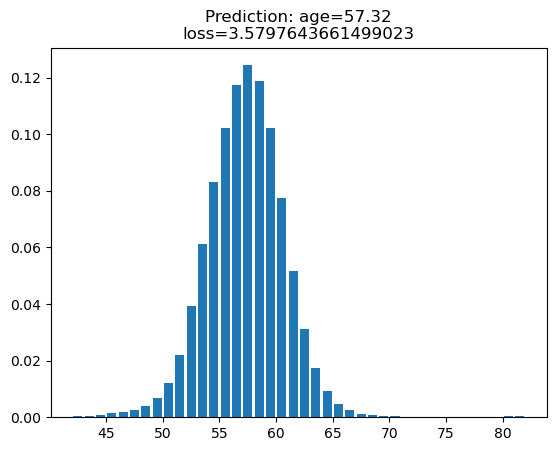

In [7]:
# convert to torch tensor
sp = (1,1) + data_np.shape
data = data_np.reshape(sp)
input_data = torch.tensor(data, dtype=torch.float32).to(device)

print(f'Input data shape: {input_data.shape}')
print(f'dtype: {input_data.dtype}')

# Transforming the true label (age) to soft label (probability distribution)
label = np.array([true_age,])
bin_range = [42,82]
bin_step = 1
sigma = 1
y, bc = dpu.num2vect(label, bin_range, bin_step, sigma)
y = torch.tensor(y, dtype=torch.float32)
print(f'Label shape: {y.shape}')

# load model
model = SFCN()
model = torch.nn.DataParallel(model)
fp_ = './brain_age/run_20190719_00_epoch_best_mae.p'
model.load_state_dict(torch.load(fp_, map_location='cpu', weights_only=True))
model.to(device)

# evaluation
model.eval()
with torch.no_grad():
    output = model(input_data)

y_hat = output[0].cpu().reshape([1, -1])
print(f'Output shape: {y_hat.shape}')
loss = dpl.my_KLDivLoss(y_hat, y).numpy()


# Prediction, Visualisation and Summary
y_hat = y_hat.numpy().reshape(-1)
y = y.numpy().reshape(-1)

plt.bar(bc, y)
plt.title('Soft label')
plt.show()

prob = np.exp(y_hat)
pred = prob@bc
plt.bar(bc, prob)
plt.title(f'Prediction: age={pred:.2f}\nloss={loss}')
plt.show()


evaluation on data with age 44-80 (315 examples)

In [8]:
# just to see how the data looks like again
df.head()

,IXI_ID,AGE,IMAGE_PATH,PREPROCESSED_IMAGE_PATH
0,13,46.71,data/IXI/T1/raw/IXI013-HH-1212-T1.nii.gz,data/IXI/T1/mni_reg/IXI013-HH-1212-T1.nii.gz
1,16,55.17,data/IXI/T1/raw/IXI016-Guys-0697-T1.nii.gz,data/IXI/T1/mni_reg/IXI016-Guys-0697-T1.nii.gz
2,19,58.66,data/IXI/T1/raw/IXI019-Guys-0702-T1.nii.gz,data/IXI/T1/mni_reg/IXI019-Guys-0702-T1.nii.gz
3,28,74.03,data/IXI/T1/raw/IXI028-Guys-1038-T1.nii.gz,data/IXI/T1/mni_reg/IXI028-Guys-1038-T1.nii.gz
4,29,59.22,data/IXI/T1/raw/IXI029-Guys-0829-T1.nii.gz,data/IXI/T1/mni_reg/IXI029-Guys-0829-T1.nii.gz


In [9]:
results_df, mae = predict_and_eval(model, df, device=device, batch_size=5)

In [10]:
print(f"MAE: {mae:.2f}")
print(f'number of test examples: {results_df.shape[0]}')
results_df.head(20)

MAE: 5.31
number of test examples: 315


,IXI_ID,true_age,pred_age
0,tensor(13),46.709999,61.380875
1,tensor(16),55.169998,64.610992
2,tensor(19),58.660000,64.502251
3,tensor(28),74.029999,68.196205
4,tensor(29),59.220001,63.303207
5,tensor(40),44.090000,54.521671
6,tensor(44),44.849998,61.272217
7,tensor(48),50.650002,58.960018
8,tensor(50),63.189999,64.197533
9,tensor(53),53.310001,62.375977


post-processing: bias correction

In [11]:
from sklearn.model_selection import train_test_split

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# --- Parameters ---
test_ratio = 0.7
random_state = 42

# --- 1) Split labeled IXI into calibration + test, stratified by age ---
bins = np.linspace(df["AGE"].min(), df["AGE"].max(), 8)
age_groups = pd.cut(df["AGE"], bins=bins, include_lowest=True)

cal_df, test_df = train_test_split(
    df, test_size=test_ratio, random_state=random_state, stratify=age_groups
)

# --- 2) Predict on calibration subset & fit bias line: pred = a*true + b ---
cal_df_out, _ = predict_and_eval(model, cal_df, device="cuda")
a, b = np.polyfit(cal_df_out["true_age"], cal_df_out["pred_age"], 1)
print(f"Bias fit: pred ≈ {a:.3f} * true + {b:.3f}")

# --- 3) Predict on test subset & apply bias correction ---
test_df_out, _ = predict_and_eval(model, test_df, device="cuda")
test_df_out["pred_age_corr"] = (test_df_out["pred_age"] - b) / a

Bias fit: pred ≈ 0.454 * true + 36.609


In [12]:
# --- 4) Compute MAE before/after bias correction ---
y_true = test_df_out["true_age"].to_numpy()
y_pred = test_df_out["pred_age"].to_numpy()
y_corr = test_df_out["pred_age_corr"].to_numpy()

mae_prev = mean_absolute_error(y_true, y_pred)
mae_corr = mean_absolute_error(y_true, y_corr)

print(f"MAE (before): {mae_prev:.2f}")
print(f"MAE (after correction):  {mae_corr:.2f}")
print(f"Calibration examples: {len(cal_df_out)}")
print(f"Test examples: {len(test_df_out)}")

test_df_out.head(20)

MAE (before): 5.32
MAE (after correction):  4.03
Calibration examples: 94
Test examples: 221


,IXI_ID,true_age,pred_age,pred_age_corr
0,tensor(414),59.740002,64.676903,61.781673
1,tensor(225),47.009998,57.670143,46.358532
2,tensor(418),59.740002,60.177490,51.877655
3,tensor(367),54.209999,59.036812,49.366817
4,tensor(501),67.110001,70.636871,74.900642
5,tensor(629),59.259998,64.717880,61.871872
6,tensor(342),48.680000,56.644138,44.100109
7,tensor(145),49.389999,60.281925,52.107536
8,tensor(368),54.209999,59.069939,49.439735
9,tensor(175),72.269997,69.448441,72.284691
